# LSTM

- 워드 임베딩 : 단어의 의미를 벡터화하는 것(주로 희소표현인 원핫인코딩에서 밀집표현으로 변환하는 것을 의미)
- 비슷한 의미 지는 것 끼리 모아서 비슷한 숫자 배정하는 것으 밀집표현 

## 데이터 로드

In [1]:
from tensorflow.keras.datasets import reuters
import numpy as np

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
# 많이 나온 단어 상위 1000개만 출력
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words = 1000, test_split = 0.2)

2113536/2110848 [==============================] - 0s 0us/step


/opt/homebrew/Caskroom/miniforge/base/envs/dl/lib/python3.8/site-packages/tensorflow/python/keras/datasets/reuters.py:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/homebrew/Caskroom/miniforge/base/envs/dl/lib/python3.8/site-packages/tensorflow/python/keras/datasets/reuters.py:144: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [3]:
X_train[0]

[1,
 2,
 2,
 8,
 43,
 10,
 447,
 5,
 25,
 207,
 270,
 5,
 2,
 111,
 16,
 369,
 186,
 90,
 67,
 7,
 89,
 5,
 19,
 102,
 6,
 19,
 124,
 15,
 90,
 67,
 84,
 22,
 482,
 26,
 7,
 48,
 4,
 49,
 8,
 864,
 39,
 209,
 154,
 6,
 151,
 6,
 83,
 11,
 15,
 22,
 155,
 11,
 15,
 7,
 48,
 9,
 2,
 2,
 504,
 6,
 258,
 6,
 272,
 11,
 15,
 22,
 134,
 44,
 11,
 15,
 16,
 8,
 197,
 2,
 90,
 67,
 52,
 29,
 209,
 30,
 32,
 132,
 6,
 109,
 15,
 17,
 12]

In [4]:
# 숫자와 문자를 매칭시켜주는 코드
word_index = reuters.get_word_index()
index_to_word={}
for key, value in word_index.items():
    index_to_word[value] = key

557056/550378 [==============================] - 0s 0us/step


In [5]:
index_to_word[1]

'the'

In [6]:
# 46가지로 뉴스를 분류
max(y_train)

45

## 데이터 전처리

In [7]:
# 뉴스마다 길이가 다름
print(len(X_train[1]))
print(len(X_train[2]))

56
139


In [8]:
# 가장 긴 뉴스의 길이
print(max(len(i) for i in X_train))

2376


In [9]:
# 뉴스의 평균 길이
print(sum(map(len, X_train))/len(X_train))

145.5398574927633


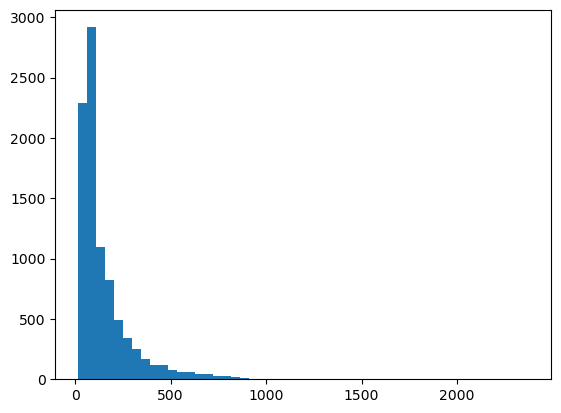

In [10]:
# 그래프로 확인
import matplotlib.pyplot as plt
plt.hist([len(s) for s in X_train], bins=50)
plt.show()

In [11]:
# 한 뉴스의 단어수를 145로 맞춰줌
# 짧은 건 앞에 0으로 공백 채우기, 긴 건짜르기
from tensorflow.keras.preprocessing import sequence

X_train = sequence.pad_sequences(X_train, maxlen=145)
X_test = sequence.pad_sequences(X_test, maxlen=145)

In [12]:
X_train.shape, X_test.shape

((8982, 145), (2246, 145))

In [13]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   1,   2,   2,   8,  43,  10, 447,
         5,  25, 207, 270,   5,   2, 111,  16, 369, 186,  90,  67,   7,
        89,   5,  19, 102,   6,  19, 124,  15,  90,  67,  84,  22, 482,
        26,   7,  48,   4,  49,   8, 864,  39, 209, 154,   6, 151,   6,
        83,  11,  15,  22, 155,  11,  15,   7,  48,   9,   2,   2, 504,
         6, 258,   6, 272,  11,  15,  22, 134,  44,  11,  15,  16,   8,
       197,   2,  90,  67,  52,  29, 209,  30,  32, 132,   6, 109,  15,
        17,  12], dtype=int32)

In [14]:
# 라베데이터 원핫인코딩
from tensorflow.keras.utils import to_categorical
y_train_en =  to_categorical(y_train)
y_test_en = to_categorical(y_test)

In [15]:
y_train_en.shape, y_test_en.shape

((8982, 46), (2246, 46))

## LSTM 모델 만들기

In [16]:
# 모델 생성
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model1 = Sequential()

# 임베딩 층 (단어를 희소표현에서 밀집표현으로 변경 = 워드 임베딩)
# Embedding(사용된 단어의 개수, 기사당 단어수)
model1.add(Embedding(1000, 145))

# LSTM층
model1.add(LSTM(100, activation='tanh'))

# 
model1.add(Dense(46, activation='softmax'))

2023-02-14 20:29:58.009294: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-14 20:29:58.010148: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [17]:
model1.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## 모델 학습

In [18]:
model1.fit(X_train, y_train_en, epochs=50)

2023-02-14 20:29:59.061162: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-14 20:29:59.065387: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50


2023-02-14 20:29:59.504497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-02-14 20:29:59.712396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-02-14 20:30:00.597451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


281/281 [==============================] - 23s 69ms/step - loss: 2.4276 - accuracy: 0.3615
Epoch 2/50
281/281 [==============================] - 20s 70ms/step - loss: 1.8642 - accuracy: 0.5131
Epoch 3/50
281/281 [==============================] - 18s 64ms/step - loss: 1.6601 - accuracy: 0.5759
Epoch 4/50
281/281 [==============================] - 19s 67ms/step - loss: 1.5241 - accuracy: 0.6197
Epoch 5/50
281/281 [==============================] - 18s 64ms/step - loss: 1.3900 - accuracy: 0.6589
Epoch 6/50
281/281 [==============================] - 18s 65ms/step - loss: 1.2932 - accuracy: 0.6804
Epoch 7/50
281/281 [==============================] - 18s 64ms/step - loss: 1.2235 - accuracy: 0.6969
Epoch 8/50
281/281 [==============================] - 18s 65ms/step - loss: 1.1490 - accuracy: 0.7125
Epoch 9/50
281/281 [==============================] - 18s 64ms/step - loss: 1.0719 - accuracy: 0.7329
Epoch 10/50
281/281 [==============================] - 18s 63ms/step - loss: 1.0284 - accurac

In [ ]:
# 비교를 위해 RNN 돌려보기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SimpleRNN
model2 = Sequential()
# 단어를 희소표현에서 밀집표현으로 변경 = 워드임베딩
model2.add(Embedding(1000,145)) # 사용된 단어의 갯수(1000), 기사당 단어수(145)
model2.add(SimpleRNN(100,input_shape=(1000,145), activation = 'tanh'))
model2.add(Dense(46, activation = 'softmax'))
model2.compile(loss = 'categorical_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])
model2.fit(X_train,y_train, epochs = 20)

# Attention

In [ ]:
# LSTM도 tanh의 한계로 뒤에 있는 말들이 더기억이 많이 됨
# Attention : 중간중간 가중치를 계산하고 문맥에 중심단어에 높은 가중치 부여

In [ ]:
!pip install attention
from attention import Attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# LSTM + Attention 
model3 = Sequential()

# 단어를 희소표현에서 밀집표현으로 변경 = 워드임베딩
model3.add(Embedding(1000,145)) # 사용된 단어의 갯수(1000), 기사당 단어수(145)
model3.add(LSTM(100, activation = 'tanh', return_sequences = True))
model3.add(Attention())
model3.add(Dense(46, activation = 'softmax'))

In [ ]:
model3.compile(loss = 'categorical_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

In [ ]:
model3.fit(X_train,y_train, epochs = 20)